In [11]:
%pprint
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit


Pretty printing has been turned OFF


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
!ls "./nature_12K/inaturalist_12K/"

train  val


In [40]:

class LimitedImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, limit_per_class=100):
        super(LimitedImageFolder, self).__init__(root, transform)
        self.limit_per_class = limit_per_class
        self.samples, self.targets = self._limit_samples()
        
    def _limit_samples(self):
        class_counts = {}
        limited_samples = []
        limited_targets = []
        
        for sample, target in zip(self.samples, self.targets):
            if target not in class_counts:
                class_counts[target] = 0
            if class_counts[target] < self.limit_per_class:
                limited_samples.append(sample)
                limited_targets.append(target)
                class_counts[target] += 1
        
        return limited_samples, limited_targets

def prepare_dataset(DATA_DIR="./nature_12K/inaturalist_12K", augment_data=False):
    train_dir = os.path.join(DATA_DIR, "train")
    val_dir = os.path.join(DATA_DIR, "val")

    if augment_data:
        train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(200),
            transforms.RandomRotation(90),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.RandomAffine(degrees=0, shear=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else:
        train_transforms = transforms.Compose([
            transforms.Resize((200, 200)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    test_transforms = transforms.Compose([
        transforms.Resize((200, 200)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_dataset = LimitedImageFolder(train_dir, transform=train_transforms, limit_per_class=100)
    val_dataset = LimitedImageFolder(val_dir, transform=test_transforms, limit_per_class=50)
    test_dataset = datasets.ImageFolder(val_dir, transform=test_transforms)

    # Create samplers
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = prepare_dataset("./nature_12K/inaturalist_12K/")


In [41]:
cnt=0
for images, labels in train_loader:
    cnt += images.shape[0]
    print(images.shape)
print(cnt)

torch.Size([64, 3, 200, 200])
torch.Size([64, 3, 200, 200])
torch.Size([64, 3, 200, 200])
torch.Size([64, 3, 200, 200])
torch.Size([64, 3, 200, 200])
torch.Size([64, 3, 200, 200])
torch.Size([64, 3, 200, 200])
torch.Size([64, 3, 200, 200])
torch.Size([64, 3, 200, 200])
torch.Size([64, 3, 200, 200])
torch.Size([64, 3, 200, 200])
torch.Size([64, 3, 200, 200])
torch.Size([64, 3, 200, 200])
torch.Size([64, 3, 200, 200])
torch.Size([64, 3, 200, 200])
torch.Size([40, 3, 200, 200])
1000


In [42]:
# Collect up to 5 images per class
images_per_class = {i: [] for i in range(len(train_loader.dataset.classes))}
for images, labels in train_loader:
    for img, label in zip(images, labels):
        label = label.item()
        if len(images_per_class[label]) < 5:
            images_per_class[label].append(img)
        if all(len(imgs) == 5 for imgs in images_per_class.values()):
            break
    if all(len(imgs) == 5 for imgs in images_per_class.values()):
        break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

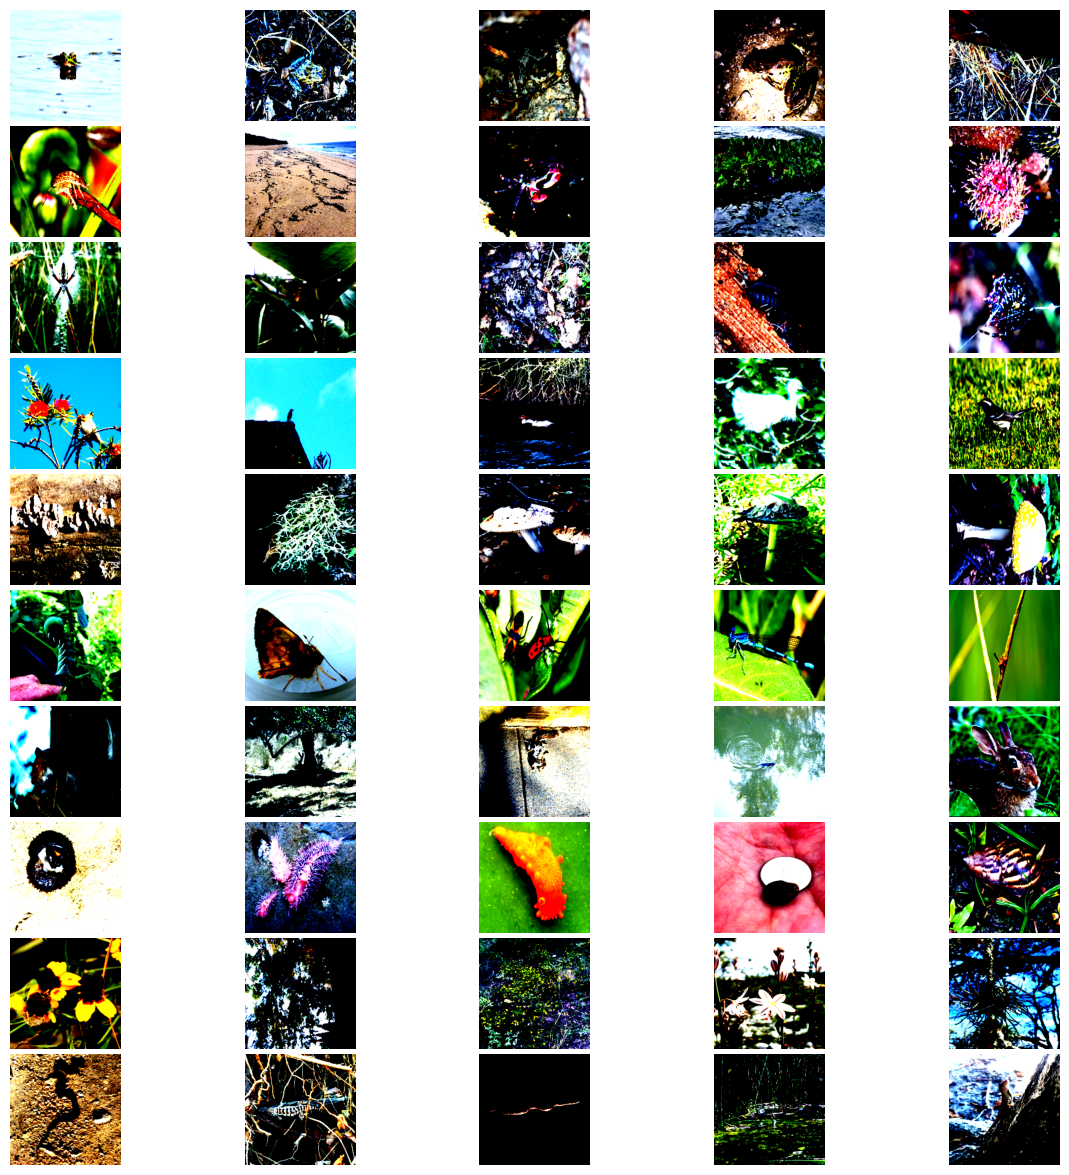

In [43]:
num_classes = len(images_per_class)
fig, axes = plt.subplots(num_classes, 5, figsize=(15, 15))

for label, imgs in images_per_class.items():
    for i, img in enumerate(imgs):
        img_np = np.transpose(img.numpy(), (1, 2, 0))
        axes[label, i%5].imshow(img_np)
        axes[label, i%5].axis('off')
        
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [44]:
# CNN model implementation
class CNN(nn.Module):
    def __init__(self,K, F, FC_size, num_classes,dropout_rate):
        super(CNN, self).__init__()

        layers = []

        # adding conv layers
        for i in range(5):
          if(i==0):
            layers.append(nn.Conv2d(3, K[i], kernel_size=F[i], padding=5))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=3, stride=1))
          else:
            layers.append(nn.Conv2d(K[i-1], K[i], kernel_size=F[i], padding=5))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=3, stride=1))

        self.conv_layers = nn.Sequential(*layers)

        # adding classifier layers
        self.flatten = nn.Flatten()

        # Dummy forward pass to calculate the flattened size
        # dummy_input = torch.randn(1, 3, 200, 200)
        # conv_output = self.conv_layers(dummy_input)
        # flattened_size = conv_output.view(1, -1).size(1)
        # print("flat ip size:",flattened_size)

        flattened_size = 259200

        self.fc_layers = nn.Sequential(
            nn.Linear(flattened_size, FC_size),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Linear(FC_size, num_classes),
            nn.Dropout(dropout_rate),
            nn.Softmax(dim=1)
        )


    def forward_propagation(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

def one_hot_vec(index, cols, rows):
    res = torch.zeros(rows, cols)
    for i in range(index.shape[0]):
        res[i,index[i]]=1
    return res


In [47]:
!nvidia-smi

Sun Jul 28 21:03:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650        Off |   00000000:01:00.0 Off |                  N/A |
| N/A   60C    P0             16W /   50W |    3812MiB /   4096MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [46]:
# device='cpu'
# Hyper-parameters
input_dim = 200
kernel_cnts = [8,16,32,32,64]
kernel_sizes = [9,9,9,9,9]
# strides = [1,2,1,2,1,2,1,2,1,2]
# paddings = [0,0,0,0,0,0,0,0,0,0]
FC_size = 100
dropout_rate=0.3
num_classes = 10
num_epochs = 15
learning_rate = 0.0001

# model
model = CNN(kernel_cnts,kernel_sizes,FC_size,num_classes,dropout_rate).to(device)

# loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

# Train model

losses = []


for epoch in range(num_epochs):
    total_steps = 0
    tot_loss = 0
    good_prediction = 0
    
    for images, labels in train_loader:
        total_steps += images.shape[0]
        images = images.to(device)
        labels = one_hot_vec(labels, num_classes, images.shape[0]).to(device)

        # Forward pass
        outputs_ = model.forward_propagation(images).to(device)

        loss = loss_fn(outputs_,labels)

        # backward prop and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        tot_loss += loss.item()
        good_prediction += (outputs_.argmax(0) == labels).type(torch.float).sum().item()

    losses.append(tot_loss)

    acc = good_prediction/total_steps
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {tot_loss}, Accuracy: {acc}')

# Save the model and optimizer state dictionaries
model_path = 'model2.pth'
optimizer_path = 'model2_optimizer.pth'

torch.save(model.state_dict(), model_path)
torch.save(optimizer.state_dict(), optimizer_path)

import gc

# Function to clear cache and collect garbage
def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()

clear_memory()

OutOfMemoryError: CUDA out of memory. Tried to allocate 314.00 MiB. GPU 

In [ ]:

# Evaluation phase
model.eval()  # Set the model to evaluation mode

# predictions on val dataset
total_images = len(val_loader) * 128
losses = []

good_prediction = 0

for images, labels in val_loader:
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs_ = model.forward_propagation(images).to(device)
    outputs_ = torch.argmax(outputs_, dim=1)

    good_prediction += (outputs_ == labels).type(torch.float).sum().item()

print("Accuracy= ",good_prediction/total_images * 100, "%")

Accuracy=  38.57421875 %
